In [2]:
import importlib
import funcs
# import the functional forms that JMP coded but with modifications from JJK.
from funcs import variably_tapered2, poisson_range, broken_plaw
import os
import emcee
import numpy
import pandas as pd
import seaborn as sns
from astropy.table import Table
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import corner

/Users/kavelaarsj/.pyenv/versions/3.9.1/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
def likelihood2(H, bias, Ho=0, Hb=7,  alpha_SI=0.67, beta_SI=0.65):
    """
    This is the vesion of the Likelihood that uses the Ho/Hb form. 
    
    The Likelihood function is derived from the version used in Bernstien et al. 2004.

    :param H: Vector of measured H values
    :param bias: Vector of bias on detection of a given object
    :param Ho: normalization of the distribution (H where we have 1 object following slope alpha_SI if beta_SI=0)
    :param Hb: the place in the function where we transition form alpha_SI to beta_SI
    :param alpha_SI: this the exponential slope to the luminosity function expressd in mass units.
    :param beta_SI: exponent of the taper, expressed in mass units.

    :return:
    """
    # we are going to do some numerical differtiation of the cummulative function along vector 'x'
    x = numpy.linspace(H.min()-3.0, H.max()+0.1)
    dx = x[1]-x[0]
    # get teh CDF as coded by J-M. but modified to be Ho/Hb
    cdf = variably_tapered2(x, Ho, Hb, alpha_SI, beta_SI)
    # compute the PDF from the CDF.
    pdf = numpy.diff(cdf)/dx
    # get a vector of H values that match the range we have observations for.
    ht = numpy.linspace(H.min(), H.max())
    dh = ht[1]-ht[0]
    # compute expected number of objects, differentially, given the PDF and bias from the observations.
    dy = bias*numpy.interp(H, x[1:]-dx/2.0, pdf)
    # Compute the differential distribution of the observed number of objects from the survey.
    dN = numpy.interp(ht, H, dy)
    # Compute the sum of the observed differential distribution
    N = dh*dN.sum()
    # compute the likelihood as described in B04
    l = -N + numpy.sum(numpy.log(dy/len(H)))
    return dy, N, l

In [4]:
def ll(params, H, bias, limits):
    """
    Compute the log-likelihood [setup to work with eemcc
    :param params: function parameters
    :param H: numpy array of H magnitudes
    :param bias: numpy array of detection bias
    :param limits: bounds on params, ll = -np.inf outside this range.
    :return: log of likelihood
    """
    # this is the list of parameters that the likelihood2 function needs.
    keys =  ['Ho', 'Hb', 'alpha_SI', 'beta_SI']
    for idx in range(len(keys)):
        # the 'limits' dictionary gives the bounds on the parameters, return -infinity if emcee explores
        # outside the range. 
        if not limits[keys[idx]][0] < params[idx] < limits[keys[idx]][1]:
            return -numpy.inf
    # send the params to the likelihood2 function
    # TODO: Use the limits dictionary to map the order. 
    dy, N, l = likelihood2(H, bias, alpha_SI=params[2], Hb=params[1], Ho=params[0], beta_SI=params[3])
    N_lim = len(H) 
    # this was a hard coded cutoff of how badly we might let the functional form get.
    # if not N_lim - numpy.sqrt(N_lim)*3 < N < N_lim+numpy.sqrt(N_lim)*3:
    #     return -numpy.inf
    return l

In [11]:
"""
emcee likelihood estimation of variably tapered exponential for H distribution

"""
importlib.reload(funcs)
# What is the cutoff in inclination to use if cold/hot not defined in the input file when doing 'classic' 
# cut to get normalization with values reported in B04 and F14
i_c = 4.0

# set the theme for the plots
sns.set_theme()
# What data are we going to be fitting an LF to

In [26]:
DETECTIONS_FILE = "All_Surveys_v11-free-cla_m.detections-full"
hlim = 8.3
# REP is the directory where DETECTIONS_FILE is located
rep = './'
# Load detection list with bias column from disk
detection_file = os.path.join(rep, DETECTIONS_FILE)
alld = Table.read(detection_file, format='ascii')
# weight data by the inverse of the bias.
alld['weight'] = 1/alld['bias']
alld.sort(['Hx', 'bias'])
# set some conditions to select sub-sets of the detection list
cold = ((alld['ifree']<= i_c) & (alld['a'] >= 42.4) & (alld['a'] <= 47.7) &(alld['Hx']>0))
small = alld['Hx'] > hlim
faint = small & cold
bright = (~small) & cold

DEEP_SURVEYS_FILE = "deep_surveys.csv"
B04_DETECTIONS_FILE = "B04-free-cla_m.detections-full"

# This is the cummulative number of detections from Bernstien as determiend by JMP.
gmb = 1.0+1.0/6023600.0+1.0/408523.71+1.0/328900.56+1.0/3098708.0+1.0/1047.3486+1.0/3497.898+1.0/22902.98+1.0/19412.24+1.0/1.35e8

In [27]:
# CDF without correcting for biases.
yraw = numpy.cumsum(numpy.ones(len(alld[cold])))
xraw = alld['Hx'][cold]
raw_cdf = pd.DataFrame({"Hx": xraw, 'raw': yraw})

# we will only 'fit' the BRIGHT detections for this dataset
yd_fit = alld['bias'][bright]
xd_fit = alld['Hx'][bright]

yd = numpy.cumsum(1/yd_fit)
xd = xd_fit
bright_cdf = pd.DataFrame({"Hx": xd, 'yd': yd})

# CDF of the full cold classical set but only
# keep the faint ones (to plot this group differently)
yf = numpy.cumsum(alld['weight'][cold])[alld['Hx'][cold] > hlim]
xf = alld['Hx'][faint]
faint_cdf = pd.DataFrame({"Hx": xf, 'yd': yf})

# compute the poisson interval consistent with the number of
# objects at each point in the cumulative distribution.
y = numpy.cumsum(numpy.ones(len(alld[bright])))
yl, yu = funcs.poisson_range(y, 0.95)

# Turn the CDF determine poisson upper/lower bounds into
# a differential bounds
yl[1:] -= yl[:-1]
yu[1:] -= yu[:-1]

# use the weights to scale the Differential poison bounded counts
yu *= alld[bright]['weight']
yl *= alld[bright]['weight']

# Take a cumulative sum of the weighted differential
yu = numpy.cumsum(yu)
yl = numpy.cumsum(yl)

# Insert a couple of points at the start of the CDF for the '0'
# detected sources brighter than the brightest object.
# (0 detections is consistent with 3.65 expected)
yu = numpy.insert(yu, 0, 3.65)
yl = numpy.insert(yl, 0, 0)

# And get a vector of 'H' values, same as the xd vector made above
# but with that bright 'non-detection' point added at the start.
# here we arbitrarily put this at H=4.8
Hx = numpy.insert(alld['Hx'][bright], 0, 4.8)
N = numpy.array(bright_cdf['yd'])
N = numpy.insert(N, 0, 0)
df = pd.DataFrame({'Hx': Hx, 'Nl': yl, 'Nu': yu, 'N': N})
df.to_csv('H_cc.csv')

(1, 100000)

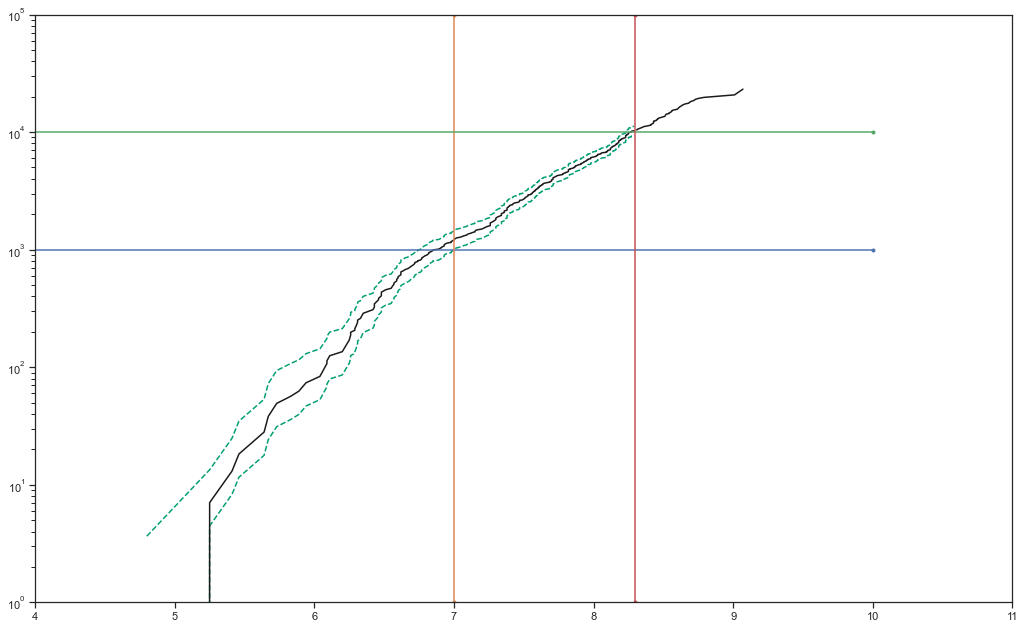

In [28]:
plt.clf()
#plt.style.use('PaperDoubleFig.mplstyle')
from matplotlib import rcParams
xsiz = 2*7.2
ysiz = 2*4.45
rcParams['figure.figsize'] = xsiz, ysiz
# setup the plot using seaborn functions
sns.set_theme(style='ticks')
sns.set_color_codes(palette='colorblind')
plt.plot(df['Hx'], df['Nl'], '--g')
plt.plot(df['Hx'], df['Nu'], '--g')
plt.plot(df['Hx'], df['N'], '-k')
plt.plot(faint_cdf['Hx'], faint_cdf['yd'], '-k')
plt.plot([0,10],[10**3, 10**3], '.-')
plt.plot([7,7],[1, 10**5], '.-')
plt.plot([0,10],[10**4, 10**4], '.-')
plt.plot([8.3,8.3],[1, 10**5], '.-')


plt.yscale('log')
plt.xlim(4, 11)
plt.ylim(1, 100000)

In [10]:
bright_cdf['yd']

0         58.700948
1         90.276372
2        115.941352
3        138.501729
4        214.666092
           ...     
114    13782.483525
115    13884.789502
116    13967.810814
117    14098.887874
118    14525.946296
Name: yd, Length: 119, dtype: float64

In [16]:
# pfit = {'shallow': {'Ho': -2.6, 'Hb': 8.2, 'alpha_SI': 0.4*5/3., 'beta_SI': 0.39},
#        'steep': {'Ho': 0.0, 'Hb': 5.9, 'alpha_SI': 0.5*5/3., 'beta_SI': 0.45}}
# Initial values to fit the variable_tappered2 function to
pfit = {'steep': {'Ho': 0.01, 'Hb': 7.1, 'alpha_SI': 0.834, 'beta_SI': 0.59},
        'shallow': {'Ho': -2.6, 'Hb': 8.1, 'alpha_SI': 0.667, 'beta_SI': 0.42}}
limits={'Ho': [-3, 3],
        'Hb': [-3, 10],
        'alpha_SI': [0.667, 0.834],
        'beta_SI': [0.1, 2.0]}

In [17]:
cols = {'steep': ':k', 'shallow': '-k'}

  0%|          | 0/2000 [00:00<?, ?it/s]/Users/kavelaarsj/.pyenv/versions/3.9.1/Python.framework/Versions/3.9/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 5/2000 [00:00<00:42, 46.81it/s]

Computing ML fit for steep asymptote
{'Ho': [-3, 3], 'Hb': [-3, 10], 'alpha_SI': (0.82566, 0.84234), 'beta_SI': [0.1, 2.0]}


  3%|▎         | 63/2000 [00:01<00:37, 51.28it/s]<ipython-input-3-13007e803628>:33: RuntimeWarning: divide by zero encountered in log
  l = -N + numpy.sum(numpy.log(dy/len(H)))
100%|██████████| 10000/10000 [03:11<00:00, 52.28it/s]


	Ho: 0.080 -0.131-0.201
	Hb: 4.374 -0.550-6.688
	alpha_SI: 0.834 0.828-0.840
	beta_SI: 0.861 0.297-1.533


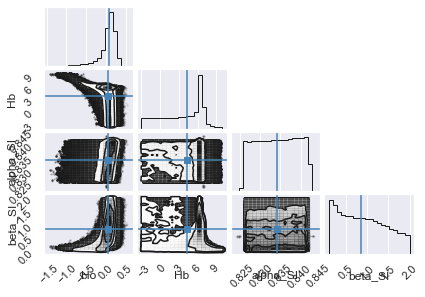

  0%|          | 0/2000 [00:00<?, ?it/s]/Users/kavelaarsj/.pyenv/versions/3.9.1/Python.framework/Versions/3.9/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 10/2000 [00:00<00:41, 47.59it/s]

Computing ML fit for shallow asymptote
{'Ho': [-3, 3], 'Hb': [-3, 10], 'alpha_SI': (0.6603300000000001, 0.67367), 'beta_SI': [0.1, 2.0]}


  8%|▊         | 163/2000 [00:03<00:40, 45.33it/s]<ipython-input-3-13007e803628>:33: RuntimeWarning: divide by zero encountered in log
  l = -N + numpy.sum(numpy.log(dy/len(H)))
100%|██████████| 10000/10000 [03:40<00:00, 45.30it/s]


	Ho: -2.188 -2.576--1.939
	Hb: 6.985 6.659-7.435
	alpha_SI: 0.667 0.663-0.672
	beta_SI: 0.711 0.381-1.089


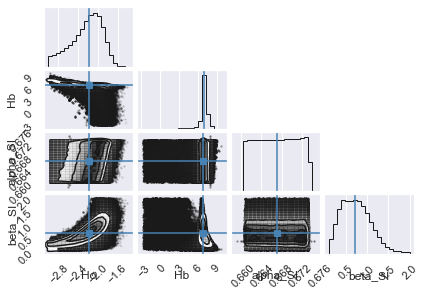

In [18]:
# Now add the functional lines for variably tapered CDF.
samples = {}
for mode in ['steep', 'shallow']:
    print(f"Computing ML fit for {mode} asymptote")
    p0 = pfit[mode]
    labels = list(p0.keys())
    alpha_SI = p0['alpha_SI']
    #limits = {}
    #for label in labels:
    #    delta = max(4,0.75*(numpy.fabs(p0[label])+1))
    #    limits[label]=p0[label]-delta, p0[label]+delta
    limits['alpha_SI'] = 0.99*p0['alpha_SI'], 1.01*p0['alpha_SI']
    print(limits)
    ivar = numpy.array((p0['Ho'], p0['Hb'], p0['alpha_SI'], p0['beta_SI']))
    ndim, nwalkers = 4, 100
    # spread the initial values around a small amount
    ivar = ivar + (numpy.random.rand(nwalkers, ndim)-0.5)*ivar*0.025
    nsteps = 10000
    # sampler = emcee.EnsembleSampler(nwalkers, ndim, ll, args=(xd, alld['bias'][bright]))
    kwargs = {'H': xd_fit, 'bias': yd_fit, 'limits': limits}
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ll, kwargs=kwargs)
    state = sampler.run_mcmc(ivar, 2000, progress=True)
    sampler.run_mcmc(state, nsteps, progress=True)
    samples[mode] = sampler.get_chain(flat=True)
    for i in range(ndim):
        mcmc = numpy.percentile(samples[mode][:, i], [16, 50, 84])
        p0[labels[i]] = mcmc[1]
        print(f"\t{labels[i]}: {mcmc[1]:.3f} {mcmc[0]:.3f}-{mcmc[2]:.3f}")
    fig = plt.figure('corner')
    corner.corner(samples[mode], labels=labels, truths=[p0[label] for label in labels], fig=fig)
    plt.show()
    # fig.savefig(f'corner_{alpha_SI*10:2.0f}.pdf')
    # fit a variable tapered functional log form.


In [57]:
from copy import deepcopy
# bfit = deepcopy(pfit)
pfit['steep']={'beta_SI': 0.499, 'Ho': 0.019, 'Hb': 4.847, 'alpha_SI': 0.834}
pfit['shallow']={'beta_SI': 0.6, 'Ho': -2.274, 'Hb': 7.065, 'alpha_SI': 0.677} 


Bad value in file 'PaperDoubleFig.mplstyle', line 5 ('figure.figsize: 2*7.2,2(4.45'): Key figure.figsize: Could not convert '2*7.2' to float


Predicted total: 98.566574343491
['cl', 'p', 'j', 'k', 'sh', 'object', 'mag', 'e_mag', 'Filt', 'Hsur', 'dist', 'e_dist', 'Nobs', 'time', 'av_xres', 'av_yres', 'max_x', 'max_y', 'a', 'e_a', 'e', 'e_e', 'i', 'e_i', 'Omega', 'e_Omega', 'omega', 'e_omega', 'tperi', 'e_tperi', 'RAdeg', 'DEdeg', 'JD', 'rate', 'MPC', 'ifree', 'Omfree', 'omfree', 'Hx', 'comp', 'bias']
OSSOS H_r limit: 8.3
Ratio of OSSOS-CCKB on on-eclitic i<5: 2.2899567080466814
Ratio of OSSOS-CCKB on FH08 sample i<5: 8.094824949782119
Ratio of OSSOS-CCKB on B04 sample i<5: 4946.306489380831
DES H_VR limit: 7.0
75 69
    ID        cl      a      e     ifree   Hx  VRmag  dist   bias Fit
                      AU            deg   mag   mag    AU            
--------- --------- ------ ------ ------- ---- ----- ------ ----- ---
    88611 CLASSICAL 44.131 0.0243  4.0269  5.8  21.8 44.967  0.14   Y
2001QR297 CLASSICAL 44.504 0.0291  4.3395 6.28  21.6 43.633  0.14   Y
    88268 CLASSICAL 42.362 0.0165 0.43869  6.3  21.6 42.252  0.16  

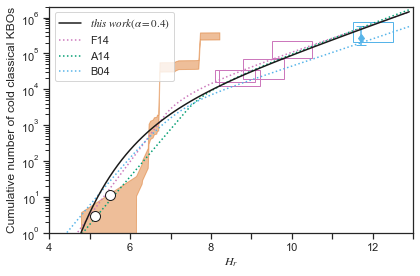

In [69]:
%matplotlib inline
# plt.interactive(False)
h = numpy.arange(5, 13, .1)
# y = funcs.variably_tapered2(h, **p0)
# plt.plot(h, y, col, alpha=0.3)
# plt.text(10.9, 8.8e4, r'$\alpha = 0.4$', fontsize=10, horizontalalignment='left', color=cols['shallow'])
# plt.text(11.1, 3.8e5, r'$\alpha = 0.5$', fontsize=10, horizontalalignment='right', color=cols['steep'])

# Plot the deep survey rectangles.
deep = Table.read(DEEP_SURVEYS_FILE, format='ascii')
rlow, rhigh = funcs.poisson_range(deep['N_cold'], 0.95)
deep['n_low'] = rlow*deep['sky_fraction']/deep['eta']
deep['n_high'] = rhigh*deep['sky_fraction']/deep['eta']

plt.clf()
plt.style.use('PaperDoubleFig.mplstyle')
# setup the plot using seaborn functions
sns.set_theme(style='ticks')
sns.set_color_codes(palette='colorblind')
# plot the bright and faint CDFs with dashed line for the faint part.
# ax = sns.lineplot(data=bright_cdf, x='Hx', y='yd', color='r', linewidth=2, zorder=10)
# sns.lineplot(data=raw_cdf, x='Hx', y='raw', color='k', alpha=0.3, linestyle="--", ax=ax)
ax = sns.lineplot(data=faint_cdf, x='Hx', y='yd', color='r', linewidth=4, zorder=10, alpha=0.5, linestyle=":")
# Now shade the area between the upper and lower limits as determined using our poisson approximation
ax.fill_between(df['Hx'], df['yl'], df['yu'], color='r', alpha=0.4, zorder=2)
plt.yscale('log')

#pfit['steep']['Ho'] = -0.065
h = numpy.arange(4, 13, .1)
for mode in ['shallow']:
    col = cols[mode]
    inds = numpy.random.randint(len(samples[mode]), size=0)
    for ind in inds:
        sample = samples[mode][ind]
        kwargs = {'Ho': sample[0], 'Hb': sample[1], 'alpha_SI': sample[2], 'beta_SI': sample[3] }
        y = funcs.variably_tapered2(h, **kwargs)
        ax.plot(h, y, col, alpha=0.01)
    y = funcs.variably_tapered2(h, **pfit[mode])
    ax.plot(h, y, col, zorder=12, label=r"$this\ work (\alpha=0.4)$")
    dy, N, l = likelihood2(xd_fit, yd_fit, **pfit[mode])
    print(f"Predicted total: {N}")
    # print(numpy.array((xd_fit, yd_fit, dy)).T)
    # x = numpy.linspace(xd_fit.min(), xd_fit.max())
    # model = (x[1] - x[0]) * numpy.interp(x, xd_fit, dy).cumsum()
    # ax.plot(x, model, col, markeredgewidth=0.3, alpha=0.7)

# plt.text(10.9, 8.8e4, r'$\alpha = 0.4$', fontsize=10, horizontalalignment='left', color=cols['shallow'][1])
# plt.text(11.1, 3.8e5, r'$\alpha = 0.5$', fontsize=10, horizontalalignment='right', color=cols['steep'][1])

# set plot configuration.
plt.xlim(4., 10.)
plt.ylim(1., 2.e6)
plt.yscale('log')
plt.xlabel(r'$H_r$')
plt.ylabel('Cumulative number of cold classical KBOs')
plt.gca().set_xticks([4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
for i, tick in enumerate(plt.gca().xaxis.get_ticklabels()):
    if i % 2 != 0:
        tick.set_visible(False)


for row in deep:
    ec = 'm'
    if 'Bern' in row['survey']:
        ec = 'c'
    rect = Rectangle((row['H_min'], row['n_low']),
                     width=row['H_max'] - row['H_min'],
                     height=row['n_high'] - row['n_low'],
                     fc='none',
                     ec=ec)
    ax.add_artist(rect)


    
# plot the specific point for detections in B04
B04 = Table.read(B04_DETECTIONS_FILE, format='ascii')
cold = B04['ifree'] <= 4.
n = cold.sum()
yb = (1./B04['bias'][cold]).sum()
xb = B04['Hx'][cold].max()
r1, r2 = funcs.poisson_range(n, 0.95)
r1 = (n - r1)*yb/n
r2 = (r2 - n)*yb/n
err = numpy.array(((r1, r2),)).T
plt.errorbar(xb, yb, yerr=err, fmt='cd', ecolor='c', capsize=5)

# plot the locations of the Bright MPC counts
plt.plot([5.13, 5.51], [3, 11], 'ok', marker='o', mec='k', mew=1, mfc='w', ms=10, zorder=10)

ax = plt.gca()
# save to file
# plt.show()
# plt.savefig('figure1.pdf')

import funcs
importlib.reload(funcs)
from astropy.coordinates import SkyCoord,HeliocentricTrueEcliptic
from astropy import units
rep = './'

# Load detection list with bias column from disk
detection_file = os.path.join(rep, "All_Surveys_v11-free-cla_m.detections-full")
DETECTIONS_FILE = "DES.cds"

ossos = Table.read(detection_file, format='ascii')
print(ossos.colnames)
ossos['coord'] = SkyCoord(ossos['RAdeg'], ossos['DEdeg'], distance=ossos['dist'], unit=('degree', 'degree', 'au'))
ossos['ecl'] = ossos['coord'].transform_to(HeliocentricTrueEcliptic)


ossos.sort('Hx')
# weight data by the inverse of the bias.
ossos['weight'] = 1/ossos['bias']

# set some conditions to select sub-sets of the detection list
ossos_hlim = 8.3
print(f"OSSOS H_r limit: {ossos_hlim:3.1f}")
cold = ((ossos['ifree'] >= 5.) & (ossos['a'] >= 42.4) & (ossos['a'] <= 47.7) & (ossos['Hx'] < ossos_hlim) & (ossos['Hx']>6.0))
ossos = ossos[cold]
# print(ossos['mag'].max())

# Load detection list with bias column from disk
detection_file = os.path.join(rep, DETECTIONS_FILE)

des = Table.read(detection_file, format='ascii.cds')
des = des[des['VRmag'] < 23.0]

des.sort('Hx')

# set some conditions to select sub-sets of the detection list
des_hlim = 6.9
des_hlim = ossos_hlim - 1.85 + 0.5

# set some conditions to select sub-sets of the detection list
cold = ((ossos['ifree'] >= 5.) & (ossos['a'] >= 42.4) & (ossos['a'] <= 47.7) &(ossos['Hx']>6))
small = ossos['Hx'] > 8.3
faint = small & cold
bright = (~small) & cold
fcold = ((ossos['i'] >= 5.) & (ossos['dist'] >= 38) & (ossos['dist'] <= 48) & (ossos['Hx']>6))
on_ecliptic = (ossos['ecl'].lat < 3*units.degree) & (ossos['ecl'].lat > -3*units.degree) & fcold & ~small
f14_to_ossos_ratio = ossos['weight'][on_ecliptic].sum()/ossos['weight'][bright].sum()
print(f"Ratio of OSSOS-CCKB on on-eclitic i<5: {1/f14_to_ossos_ratio}")
on_ecliptic = (ossos['ecl'].lat < 0*units.degree) & (ossos['ecl'].lat > -1.5*units.degree) & fcold & ~small
FH08_to_ossos_ratio = ossos['weight'][on_ecliptic].sum()/ossos['weight'][bright].sum()
print(f"Ratio of OSSOS-CCKB on FH08 sample i<5: {1/FH08_to_ossos_ratio}")
on_ecliptic = (ossos['ecl'].lat < 3*units.degree) & (ossos['ecl'].lat > -3*units.degree) & fcold & ~small
B04_to_ossos_ratio = 6*360*ossos['weight'][bright].sum()/(ossos['weight'][on_ecliptic].sum())
print(f"Ratio of OSSOS-CCKB on B04 sample i<5: {B04_to_ossos_ratio}")


print(f"DES H_VR limit: {des_hlim:3.1f}")
# print(des[des['Hx'] < 5])
cold = ((des['ifree'] <= 4.) & (des['a'] >= 42.4) & (des['a'] <= 47.7) & (des['cl'] == 'CLASSICAL') & (des['Hx'] < des_hlim))
fcold = ((des['ifree'] <= 5.) & (des['dist'] >= 39) & (des['dist'] <= 48) & (des['cl'] == 'CLASSICAL') & (des['Hx'] < des_hlim))
print(fcold.sum(), cold.sum())
print(des[(fcold) & (~cold)])
des = des[cold]
# correct to go from VR calibrated against USNO-B red to r
# Comparing the DES H_VR value to MBOSS H_R values for objects in common gives <H_R - H_VR> = -0.01
#
# and Jordi et al. (2005) [https://www.sdss.org/dr12/algorithms/sdssubvritransform/] give
#
# r-R   =     (0.267 ± 0.005)*(V-R)  + (0.088 ± 0.003) if V-R <= 0.93
# r-R   =     (0.77 ± 0.04)*(V-R)    - (0.37 ± 0.04)   if V-R >  0.93
#
# Looking at Peixinho <V-R> = 0.65 or so [Figure 3 from Wes resent ColOSSOS paper]
# Using the MBOSS VR colors for the DES objects in MBOSS gives <V-R> = 0.59 and thus r-R = 0.267*0.59 + 0.088 = 0.25
# and then subtract one to go from H_DES to
des['Hx'] += 0.25
# des['bias'] *= 0.5
# in the zone where ossos and des overlap we have 2 CDFs.  Give each weight based on their relative bias factor
# total_bias = ossos['bias'][ossos['Hx'] < des_hlim].mean()+des['bias'].mean()
# ossos_weight = 4*ossos['bias'][ossos['Hx'] < des_hlim].mean()/total_bias
# des_weight = 1/des['bias']
#des_weight = 4*des['bias'].mean()/total_bias
# print(f"OSSOS and DES combined with OSSOS weighted as {ossos_weight/2:3.1f} and DES weighted as {des_weight/2:3.1f} for H_VR < {des_hlim:3.1f}")
# ossos['bias'][ossos['Hx'] < des_hlim] *= ossos_weight
# des['bias'] *= des_weight
# weight data by the inverse of the bias.
des['weight'] = 1/des['bias']
ossos['weight'] = 1/ossos['bias']
print(ossos['weight'][ossos['Hx']<des_hlim].sum(), des['weight'].sum())
# alld = vstack([ossos, des])
des.sort('Hx')

# plot the raw CDF without correcting for biases.
yraw = numpy.cumsum(numpy.ones(len(des)))
# Make a debiased CDF of the bright cold classical objects detections
yd = numpy.cumsum(des['weight'])
xd = des['Hx']

# compute the poisson interval consistent with the number of
# objects at each point in the cumulative distribution.
y = numpy.cumsum(numpy.ones(len(des)))
yl, yu = poisson_range(y, 0.95)
# Turn the CDF determine poisson upper/lower bounds into
# a differential
yl[1:] -= yl[:-1]
yu[1:] -= yu[:-1]
# use the weights to scale the Differential poison bounded counts
yu *= des['weight']
yl *= des['weight']
# Take a cumulative sum of the weighted differential
yu = numpy.cumsum(yu)
yl = numpy.cumsum(yl)
# Insert a couple point at the start of the CDF for the '0'
# detected sources brighter than the brightest object.
# here we arbitrarily put this at H=5
yu = numpy.insert(yu, 0, 3.65)
yl = numpy.insert(yl, 0, 0)
# And get a vector of 'H' values, same as the xd vector made above
# but with that bright 'non-detection' point added at the start.
Hx = numpy.insert(xd, 0, 5)
df = pd.DataFrame({'Hx': Hx, 'yl': yl, 'yu': yu})

# setup the plot using seaborn functions
sns.set_theme(style='ticks')
sns.set_color_codes(palette='colorblind')

# plot the bright and faint CDFs with dashed line for the faint part.
des_col = 'g'
# ax.plot(xd, yd, '-', color=des_col, linewidth=2)
# plt.gca().plot(alld['Hx'], yraw, '--', color=des_col, alpha=0.5)
# Now shade the area between the upper and lower limits as determined using our poisson approximation
# ax.fill_between(df['Hx'], df['yl'], df['yu'], color=des_col, alpha=0.3, zorder=1)
publfs = {'F14': [1.5, 0.38, 7.36, 6.9], 'A14': [1.32, 0.42, 7.36, 7.2+0.25]} #, 'A14o': [1.32, 0.42, 7.36, 7.2]}

plcol = {'F14': 'm', 'A14': des_col, 'A14o': des_col}
hlims = {'F14': (5., 8.0), 'A14': (5., 7.3), 'A14o': (5., 7.3)}
scales = {'F14': 1.8*6*360/f14_to_ossos_ratio, 'A14': 3.64*1.5*360.0, 'A14o': 1/0.00055}
h = numpy.arange(4, 13, 0.1)
dh = 0.1
for group in publfs:
    xcond = (xd < hlims[group][1]) & (xd > hlims[group][0])
    hcond = (h < hlims[group][1]) * (h > hlims[group][0])
    fn = scales[group]*funcs.fraser(h, *publfs[group], dh=dh)
    # print(h[hcond][-1], xd[xcond][-1])
    # print(group, publfs[group], hlims[group], yd[xcond][-1], fn[hcond].sum(), fn[hcond].sum()/yd[xcond][-1])
    fn = numpy.cumsum(fn) # * yd[xcond][-1]/fn[hcond].sum()
    ax.plot(h, fn, f':{plcol[group]}', label=group, zorder=3)

# params, covar = optimize.curve_fit(func, xd[xd <8], yd[xd < 8])
# N = double_plaw([hexp, ])
# fn = Nexp*double_plaw(h)/N
# fn = double_plaw(h, dh=1)*B04_to_ossos_ratio
# plt.plot(h, fn, ':k', label='B04', alpha=1)
h = h - 0.25
fn = funcs.double_plaw(h, R_eq=22.8, dh=1)*6*360/0.9
h = h + 0.25
ax.plot(h, fn, ':c', label='B04', zorder=4)



# set plot configuration.
# CFEPS
# plt.plot([8-0.9], [3900], 'sr')
# Table 4 from Adam's et al.
# plt.plot([5.15, 5.25, 6.25, 7.45, 7.75], [4, 19, 200, 3400, 4500], 'sk')
# ax.xlim(4., 13.)
# ax.ylim(1., 2.e6)
# ax.yscale('log')
# ax.xlabel(r'$H_r$')
# ax.ylabel('Cumulative number of cold classical KBOs')
# ax.set_xticks([4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
# for i, tick in enumerate(plt.gca().xaxis.get_ticklabels()):
#    if i % 2 != 0:
#        tick.set_visible(False)

# save to file
plt.legend()
plt.savefig('figure2.pdf')